<a href="https://colab.research.google.com/github/JihyeLimm/Quest/blob/main/Qyest4/Ex8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ex8. 네이버 영화리뷰 텍스트 감성분석하기

In [ ]:
import os
from google.colab import drive
drive.mount('/gdrive', force_remount = True)
os.chdir("/gdrive/MyDrive/AIFFEL/230522/Mecab-ko-for-Google-Colab")
os.getcwd()

Mounted at /gdrive


'/gdrive/MyDrive/AIFFEL/230522/Mecab-ko-for-Google-Colab'

Mecab 다운로드 및 확인
>https://github.com/SOMJANG/Mecab-ko-for-Google-Colab

In [ ]:
#! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
!bash install_mecab-ko_on_colab_light_220429.sh

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()
text = u"""이제 구글 코랩에서 Mecab-ko라이브러리 사용이 가능합니다. 읽어주셔서 감사합니다."""
nouns = mecab.nouns(text)
print(nouns)

['구글', '랩', '라이브러리', '사용', '가능', '감사']


In [ ]:
drive.mount('/gdrive', force_remount = True)
os.chdir("/gdrive/MyDrive/AIFFEL/230522")
os.getcwd()

Mounted at /gdrive


'/gdrive/MyDrive/AIFFEL/230522'

라이브러리

In [ ]:
import keras
import tensorflow as tf
from keras.utils import pad_sequences
from keras.layers import Input, Embedding, GRU, Dense
from keras.models import Model
from tensorflow.keras.initializers import Constant

import pandas as pd
import numpy as np

import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

from collections import Counter

import matplotlib.pyplot as plt

#from konlpy.tag import Mecab

데이터 준비 및 전처리

In [ ]:
#데이터 불러오기
train_data = pd.read_table('/gdrive/MyDrive/AIFFEL/230522/data/ratings_train.txt')
test_data = pd.read_table('/gdrive/MyDrive/AIFFEL/230522/data/ratings_test.txt')

print(train_data.shape, test_data.shape, "\n")
train_data.head(3)

(150000, 3) (50000, 3) 



,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [ ]:
#data shuffle
train_data = train_data.sample(frac=1)
print(train_data.shape)
train_data.head(3)

(150000, 3)


,id,document,label
125853,5059270,1탄은 잼께봤는데 2탄은 왜이러니.....,0
65118,5705888,츄레기 영화.. 이 작품은 '청계천'에서 구할 수'도' 있는 K2소총 복제품에 가깝다.,0
96875,471551,"그나마 일본판보다 나은점은, 제니퍼 코넬리를 볼수있다는거",0


In [ ]:
#중복데이터 확인  -> train, test모두 document에 중복된 행 있음 
print("train_data중복:", train_data.duplicated(subset=['document']).sum())
print("test_data중복:", test_data.duplicated(subset=['document']).sum(), "\n")


#결측치 확인 -> train, test모두 document에 결측치 있음 
print("Train_data info\n")
train_data.info()
print("\n")
print("Test_data info\n")
test_data.info()

train_data중복: 3817
test_data중복: 842 

Train_data info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 125853 to 45040
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


Test_data info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [ ]:
#데이터 전처리 및 word_to_index 생성
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 10000

def load_data(train_data, test_data, num_words = num_words):
  #데이터 중복제거
  train_data.drop_duplicates(subset=['document'], inplace=True)
  test_data.drop_duplicates(subset=['document'], inplace=True)
  
  #NaN 결측치 제거
  train_data = train_data.dropna(how = 'any')   
  test_data = test_data.dropna(how = 'any') 

  #토큰화 및 불용어 제거
  X_train = []
  for sentence in train_data['document']:
    temp_X = tokenizer.morphs(sentence)   # 한국어 토크나이저로 토큰화
    temp_X = [word for word in temp_X if not word in stopwords]  # 불용어(Stopwords) 제거
    X_train.append(temp_X)

  X_test = []
  for sentence in test_data['document']:
    temp_X = tokenizer.morphs(sentence)   # 한국어 토크나이저로 토큰화
    temp_X = [word for word in temp_X if not word in stopwords]  # 불용어(Stopwords) 제거
    X_test.append(temp_X)

  words = np.concatenate(X_train).tolist()
  counter = Counter(words)
  counter = counter.most_common(num_words-4)
  vocab = ['', '', '', ''] + [key for key, _ in counter]
  word_to_index = {word:index for index, word in enumerate(vocab)}

  #사전word_to_index 구성
  def wordlist_to_indexlist(wordlist):
      return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
      
  X_train = list(map(wordlist_to_indexlist, X_train))
  X_test = list(map(wordlist_to_indexlist, X_test))
      
  return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

print(len(X_train))  #146182
print(len(X_test))   #49157

print(X_train[0])

146182
49157
[66, 1147, 102, 1173, 25, 23, 110, 1147, 63, 780, 112, 4, 378]


In [ ]:
#index_to_word생성
index_to_word = {index:word for word, index in word_to_index.items()}

#"<BOS>, <PAD>, <UNK>"는 관례적으로 딕셔너리 맨 앞에 넣어줌
index_to_word[0]="<PAD>"  # 패딩용 단어
index_to_word[1]="<BOS>"  # 문장의 시작지점
index_to_word[2]="<UNK>"  # 사전에 없는(Unknown) 단어

print(len(index_to_word))

#딕셔너리를 {텍스트:인덱스}구조로 변환
word_to_index = {word:index for index, word in index_to_word.items()}
print(word_to_index["<PAD>"])

10000
0


In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]
    # 단, 모든 문장은 <BOS>로 시작

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

모델 구성을 위한 데이터 분석 및 가공

문장길이 평균 :  15.971019612059036
문장길이 최대 :  116
문장길이 표준편차 :  12.844062009473818


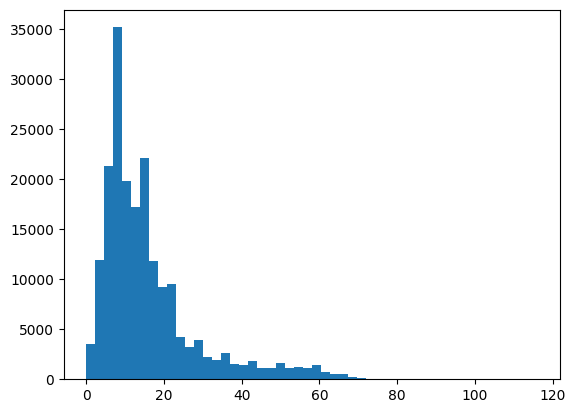

In [ ]:
#데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

#text 길이 분포 -> 20이후부터 급격하게 감소, 60이후로 데이터 거의 없음 
plt.hist([len(s) for s in total_data_text], bins=50)
plt.show()

In [ ]:

#적절한 최대 문장 길이(maxlen) 지정: (평균 + 4*표준편차)로 가정 => 67
max_tokens = np.mean(num_tokens) + 4*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)   
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

#패딩 추가
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(x_train.shape)  
print(x_test.shape)  

pad_sequences maxlen :  67
전체 문장의 0.9975632106235826%가 maxlen 설정값 이내에 포함됩니다. 
(146182, 67)
(49157, 67)


Validation set 구성

In [ ]:
#validation set 분리

import random
x_val = x_train[:20000]
y_val = y_train[:20000]

partial_x_train = x_train[20000:]
partial_y_train = y_train[20000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(126182, 67)
(126182,)


모델구성

In [ ]:
#model 1: CNN

vocab_size = 10000
word_vector_dim = 100

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None, )))
model1.add(tf.keras.layers.Conv1D(16, 7, activation = 'relu'))
model1.add(tf.keras.layers.MaxPooling1D(5))
model1.add(tf.keras.layers.Conv1D(16, 7, activation = 'relu'))
model1.add(tf.keras.layers.GlobalMaxPooling1D())
model1.add(tf.keras.layers.Dense(8, activation = 'relu'))
model1.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 conv1d (Conv1D)             (None, None, 16)          11216     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 8)                 1

In [ ]:
#model 2: LSTM

vocab_size = 10000
word_vector_dim = 100

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None, )))
model2.add(tf.keras.layers.LSTM(128)) 
model2.add(tf.keras.layers.Dense(128, activation = 'relu'))
model2.add(tf.keras.layers.Dense(64, activation = 'relu'))
model2.add(tf.keras.layers.Dense(8, activation = 'relu'))
model2.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         1000000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,142,545
Trainable params: 1,142,545
No

In [ ]:
#model 3
vocab_size = 10000
word_vector_dim = 100

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1000000   
                                                                 
 global_max_pooling1d_1 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 8)                 808       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


모델학습 및 그래프 시각화

Epoch 1/5
247/247 [==============================] - 25s 88ms/step - loss: 0.0539 - accuracy: 0.9794 - val_loss: 1.1117 - val_accuracy: 0.8370
Epoch 2/5
247/247 [==============================] - 9s 38ms/step - loss: 0.0480 - accuracy: 0.9818 - val_loss: 0.9908 - val_accuracy: 0.8360
Epoch 3/5
247/247 [==============================] - 5s 22ms/step - loss: 0.0445 - accuracy: 0.9826 - val_loss: 1.1858 - val_accuracy: 0.8384
Epoch 4/5
247/247 [==============================] - 5s 19ms/step - loss: 0.0431 - accuracy: 0.9832 - val_loss: 1.1386 - val_accuracy: 0.8383
Epoch 5/5
247/247 [==============================] - 4s 18ms/step - loss: 0.0376 - accuracy: 0.9852 - val_loss: 1.2274 - val_accuracy: 0.8378
1537/1537 - 4s - loss: 1.2268 - accuracy: 0.8333 - 4s/epoch - 3ms/step
[1.2268223762512207, 0.8333299160003662]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


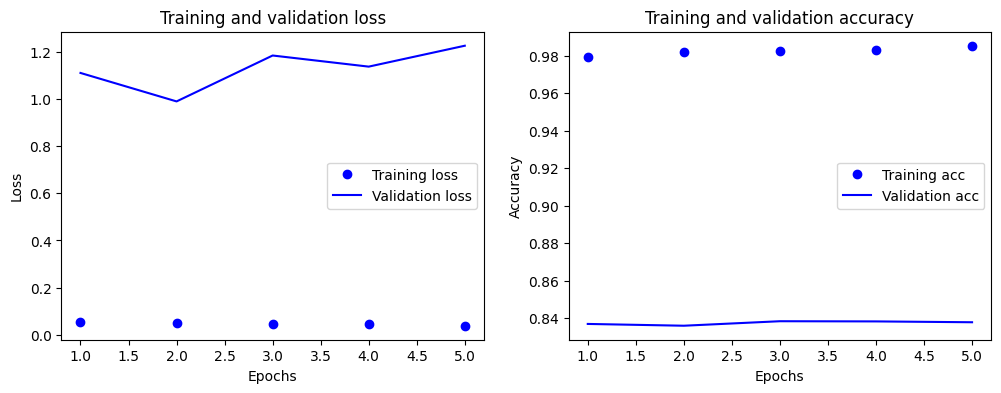

In [ ]:
#모델학습

model = model2    #model 2: LSTM

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

epochs = 5

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

#테스트셋으로 모델 평가
results = model.evaluate(x_test, y_test, verbose = 2)
print(results)


"""
loss를 그려 보면, 몇 epoch까지의 트레이닝이 적절한지 최적점을 추정가능
validation loss의 그래프가 train loss와의 이격이 발생하게 되면 
더 이상의 트레이닝은 무의미
"""

#history변수에 저장된 매 epoch rain/validation loss, accuracy 그래프 그리기

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들


acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,4))

#training & validation loss graph

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"입니다
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#training & validation Accuracy graph
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

학습된 임베딩레이어 분석
>gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석
>>결과: "재미"유사단어 찾기 결과 사전학습 임베딩 결과가 좀 더 설득력있음 -> 감성 분류 태스크를 잠깐 학습한 것만으로 워드 벡터가 유의미하게 학습되기는 어려움

In [ ]:
#학습한 embedding파라미터 저장
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)  # shape: (vocab_size, embedding_dim)


#지정된 디렉터리에 워드벡터 파일 저장
word2vec_file_path = "/gdrive/MyDrive/AIFFEL/230522/data/my_emb.txt"
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

#단어개수만큼의 워드벡터 파일에 기록
vectors = model.get_weights()[0]
for i in range(4, vocab_size):
  f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

#gensim에서 제공하는 패키지 이용해, 위의 임베딩 파라미터 읽어서 word vector로 활용 가능
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary = False)
vector = word_vectors['재미']
len(vector)

word_vectors.similar_by_word("재미")  
#감성 분류 태스크를 잠깐 학습한 것만으로 워드 벡터가 유의미하게 학습되기는 어려움

(10000, 100)


[('우정', 0.6779678463935852),
 ('매너', 0.6453362703323364),
 ('이리', 0.6433844566345215),
 ('힘', 0.6389769315719604),
 ('진보', 0.6343671083450317),
 ('잼', 0.6258286237716675),
 ('>.<', 0.6130895614624023),
 ('참여', 0.6113858222961426),
 ('아름다운', 0.6052476763725281),
 ('몰입', 0.6049667596817017)]

In [ ]:
#사전학습된 워드임베딩 모델: Word2Vec활용
word2vec_file_path = "/gdrive/MyDrive/AIFFEL/230522/data/word2vec_ko.model"
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv["재미"]
len(vector)

word_vectors.wv.similar_by_word("재미")  

[('묘미', 0.6163142919540405),
 ('취미', 0.6034970283508301),
 ('흥미', 0.5939850211143494),
 ('유머', 0.5888698101043701),
 ('보람', 0.5689517259597778),
 ('즐거움', 0.5631207823753357),
 ('개그', 0.5552946329116821),
 ('이야기', 0.5536993741989136),
 ('연애', 0.552293598651886),
 ('열의', 0.546456515789032)]

한국어 Word2Vec 임베딩 활용하여 성능 개선

In [ ]:
#모델 임베딩 레이어를 Word2Vec으로 교체
# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 100  # Word2Vec dimension
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4, vocab_size):
  if index_to_word[i] in word2vec.wv:
    embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [ ]:
#모델 선언

vocab_size = 10000
word_vector_dim = 100

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size,
                                    word_vector_dim,
                                    embeddings_initializer = Constant(embedding_matrix), 
                                    # 카피한 임베딩을 여기서 활용
                                    input_length = maxlen,
                                    trainable = True)) #trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(128)) 
model.add(tf.keras.layers.Dense(128, activation = 'relu'))
model.add(tf.keras.layers.Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dense(8, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model.summary()

#모델 학습
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

epochs = 5
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)


#테스트셋 이용한 모델 평가   => 85%이상 달성
results = model.evaluate(x_test, y_test, verbose = 2)
print("\n\n", results)   #epoch 5 [0.32903558015823364, 0.8616880774497986]

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 67, 100)           1000000   
                                                                 
 lstm_9 (LSTM)               (None, 128)               117248    
                                                                 
 dense_40 (Dense)            (None, 128)               16512     
                                                                 
 dense_41 (Dense)            (None, 64)                8256      
                                                                 
 dense_42 (Dense)            (None, 8)                 520       
                                                                 
 dense_43 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,142,545
Trainable params: 1,142,545
N

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


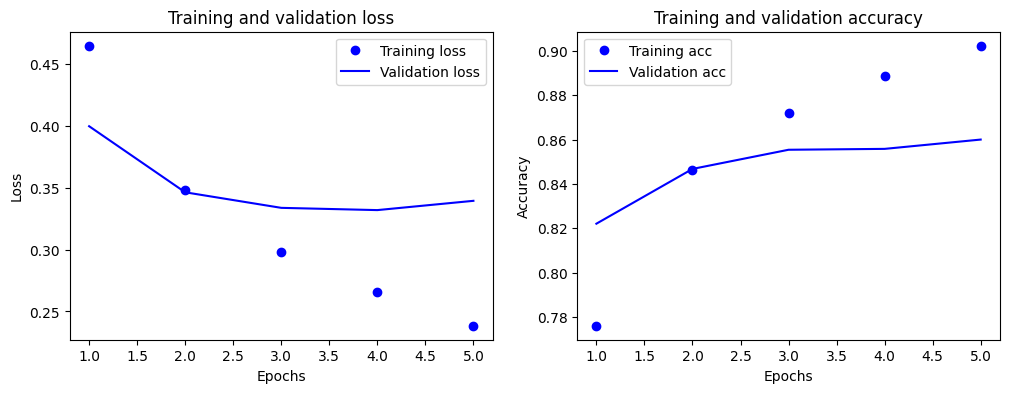

In [ ]:
#loss, accuracy 그래프 그리기
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,4))

#training & validation loss graph

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"입니다
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#training & validation Accuracy graph
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()